the anndata used in this tutorial can be downloaded [here](https://www.dropbox.com/sh/zfei28541s581qc/AACUu7KcKKaHza0UdtDcrhMta?dl=0)

# import

In [1]:
from simCAS import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Read real data and calculate the statistics

In [2]:
# read the anndata
prefix_='Buenrostro_2018'
resultdir='/data1/lichen/code/second/scATAC_integration/data/scATACdata_total/process/{0}/'.format(prefix_)
adata=sc.read(resultdir+'adata_forsimulation.h5ad')

peak_mean=np.log(cal_pm(adata)+1)
lib_size=np.log(cal_lib(adata)+1)
nozero=np.log(cal_nozero(adata)+1)

if you don't have an input peak-by-cell matrix, you can directly use our pre-calculated statistics of Buenrostro2018 dataset. And we provide the files in github 'data' folder. The default values for library size, peak mean and non-zero proportion can be read as below:

In [ ]:
peak_mean=pd.read_csv('../data/peak_mean_log.csv',index_col=0)
lib_size=pd.read_csv('../data/library_size_log.csv',index_col=0)
nozero=pd.read_csv('../data/nozero_log.csv',index_col=0)

peak_mean=np.array(peak_mean['peak mean'])
lib_size=np.array(lib_size['library size'])
nozero=np.array(nozero['nozero'])

# setting the convariance matrix

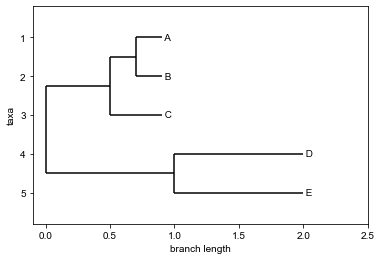

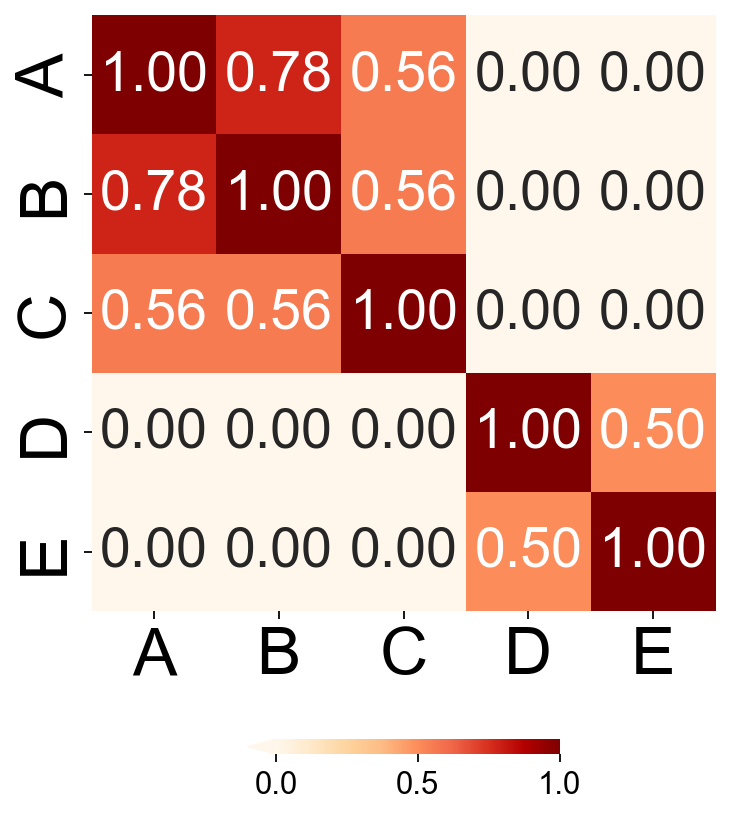

In [3]:

    
tree_text="(((A:0.2,B:0.2):0.2,C:0.4):0.5,(D:1,E:1):1);"
tree = Phylo.read(StringIO(tree_text), "newick")
Phylo.draw(tree)

ape = importr('ape')
phyla=ape.read_tree(text=tree_text)
corr_matrix=np.array(ape.vcv_phylo(phyla,cor=True))


pops_name=['A','B','C','D','E']
df_corr=pd.DataFrame(corr_matrix,columns=pops_name,index=pops_name)


sc.settings.set_figure_params(dpi=80,facecolor='white')
plt.figure(figsize=(5, 7))
cbar_kws = {"orientation":"horizontal", "shrink":0.5,'extend':'min', 'extendfrac':0.1}
ax = sns.heatmap(df_corr, 
                 vmin=0, 
                 vmax=1,
                 cmap='OrRd',
                 cbar_kws=cbar_kws,
                 annot_kws={'fontsize': 25},
                # annot_kws={'fontsize': 10, 'fontstyle': 'italic', 'color':'r', 'alpha': 0.6,
                #        'rotation': 'vertical', 'verticalalignment': 'center', 'backgroundcolor': 'w'},
                  annot=True, 
                 fmt='.2f',
                )
ax.yaxis.set_tick_params(labelsize = 30)
ax.xaxis.set_tick_params(labelsize = 30)
# plt.savefig(save_dir+'{0}_corr_matrix_{1}.pdf'.format(prefix_,tree_list[i]),facecolor='white',bbox_inches='tight')
plt.show()

# generate synthetic data

the meanings of parameters are shown below:

In [4]:
?simCAS_generate

Signature:
simCAS_generate(
    peak_mean=None,
    lib_size=None,
    nozero=None,
    n_peak=100000.0,
    n_cell_total=1500,
    rand_seed=2022,
    zero_prob=0.5,
    zero_set='all',
    effect_mean=0,
    effect_sd=1,
    min_popsize=300,
    min_pop=None,
    tree_text=None,
    pops_name=None,
    pops_size=None,
    embed_mean_same=1,
    embed_sd_same=0.5,
    embed_mean_diff=1,
    embed_sd_diff=0.5,
    len_cell_embed=12,
    n_embed_diff=10,
    n_embed_same=2,
    simu_type='discrete',
    correct_iter=2,
    activation='exp_linear',
    two_embeds=True,
    adata_dir=None,
    lib_simu='estimate',
    distribution='Poisson',
    bw_pm=0.0001,
    bw_lib=0.05,
    bw_nozero=0.05,
    real_param=False,
    K=None,
    A=None,
)
Docstring:
generate scCAS data with three modes: pseudo-cell-type mode, discrete mode, continuous mode.

Parameter
----------
peak_mean: 1D numpy array, default=None
    Real peak mean of scCAS data. Used for statistical estimation.
lib_size: 1D nump

In [5]:
adata_final=simCAS_generate(peak_mean=peak_mean,lib_size=lib_size,nozero=nozero,n_peak=adata.shape[1],
                n_cell_total=1500,rand_seed=2022,tree_text=tree_text,pops_name=pops_name,simu_type='discrete',
                    activation='exp_linear')

**********start generate effect vector...**********
**********generate effect finished!**********
**********start generate cell embedding...**********
simulation type is discrete
**********generate cell embedding finished**********
**********start ZIP correction...**********
**********ZIP correction finished!**********
**********generate counts finshed!**********


In [6]:
adata_final.X = adata_final.X.astype(np.float32)
adata_final

AnnData object with n_obs × n_vars = 1500 × 169221
    obs: 'celltype'

## UMAP visualization

In [7]:
import episcanpy.api as epi

In [8]:
# Perform Signac TF-IDF (count_mat: peak*cell)
def tfidf2(count_mat): 
    tf_mat = 1.0 * count_mat / np.tile(np.sum(count_mat,axis=0), (count_mat.shape[0],1))
    signac_mat = np.log(1 + np.multiply(1e4*tf_mat,  np.tile((1.0 * count_mat.shape[1] / (np.sum(count_mat,axis=1)+1) ).reshape(-1,1), (1,count_mat.shape[1]))))
    return scipy.sparse.csr_matrix(signac_mat)

**finish TF-IDF**


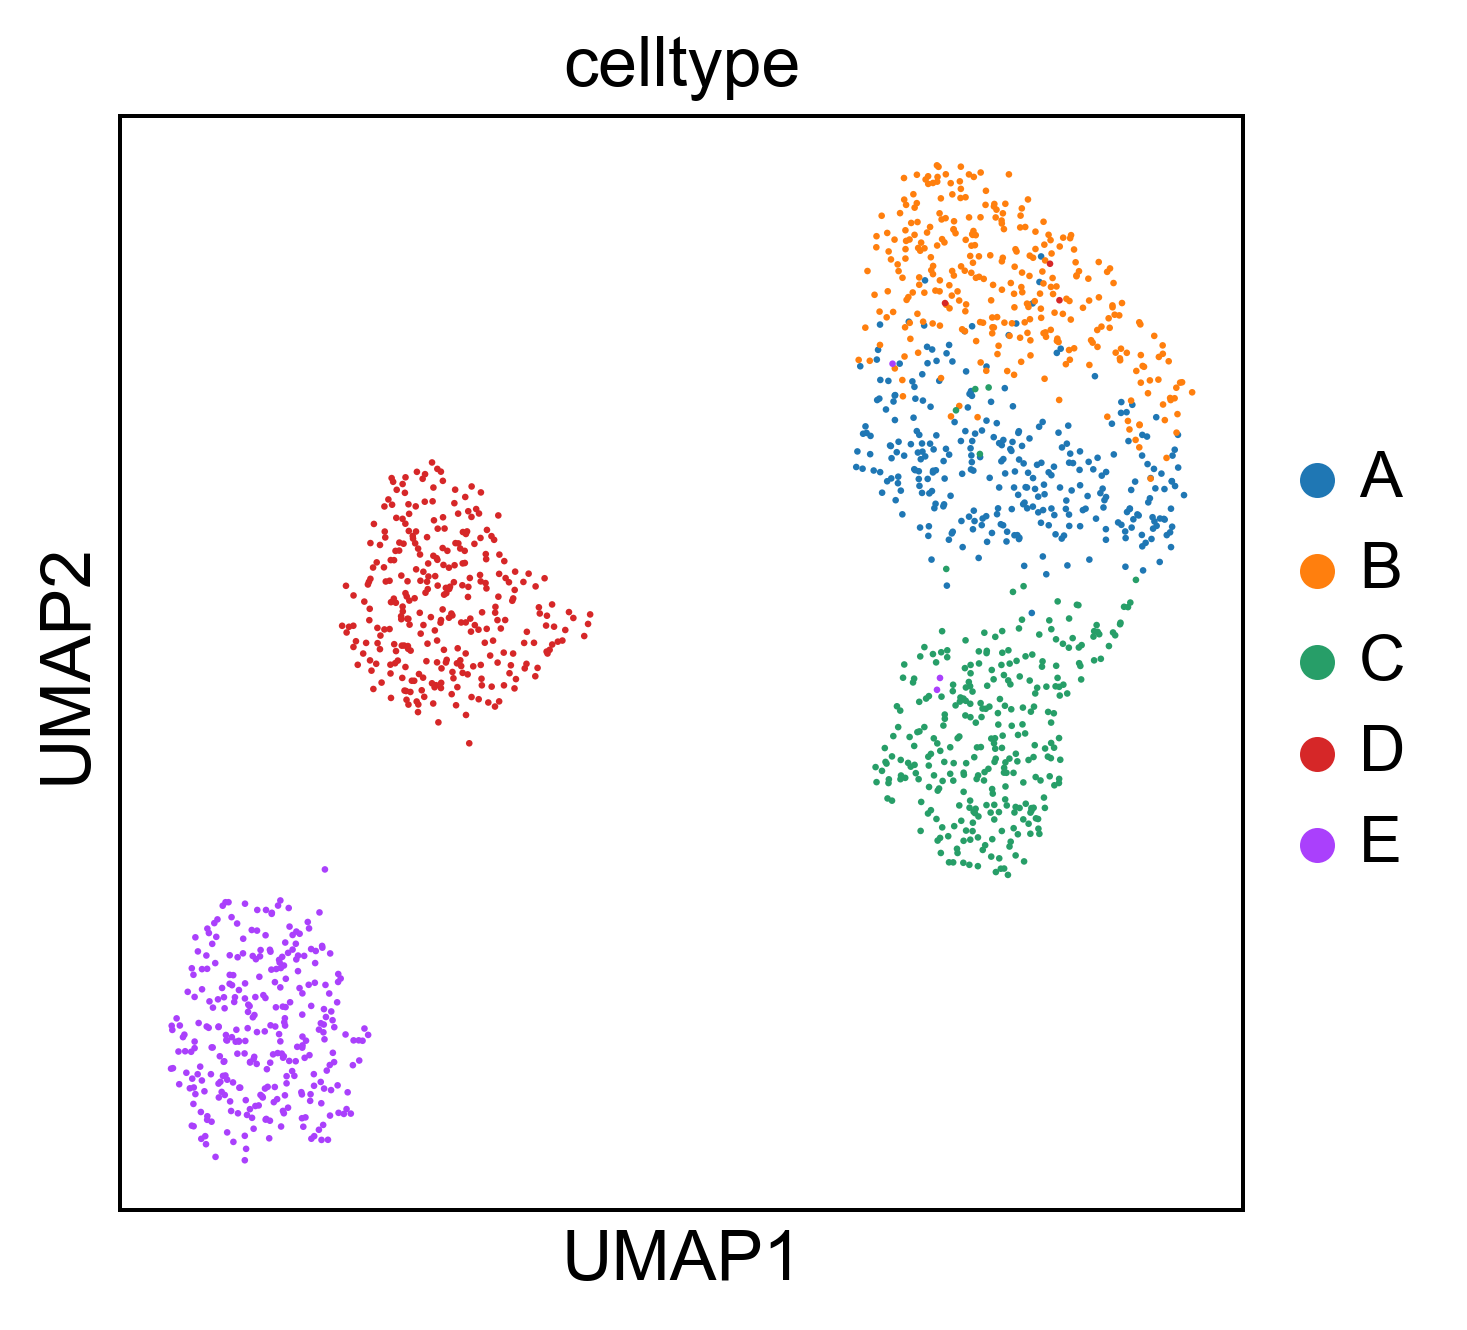

In [9]:
nb_feature_selected = 50000
seed=2022
adata_final = epi.pp.select_var_feature(adata_final,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

adata_final.X=tfidf2(adata_final.X.T).T
print("**finish TF-IDF**")

#-----plot umap
sc.tl.pca(adata_final, n_comps =50,svd_solver='arpack',random_state=seed)
sc.pp.neighbors(adata_final, n_neighbors=10, n_pcs=20,random_state=seed)
sc.tl.umap(adata_final,random_state=seed)
sc.tl.leiden(adata_final,random_state=seed)

sc.settings.set_figure_params(dpi=180,facecolor='white',vector_friendly=False)

sc.pl.umap(adata_final, color=['celltype'],size=7)